In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
% matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from hcnn.hcnn import HCNN
from hcnn.loss_functions import LogCosh

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from hcnn import HCNN
from loss_functions import LogCosh

# Synthetic data

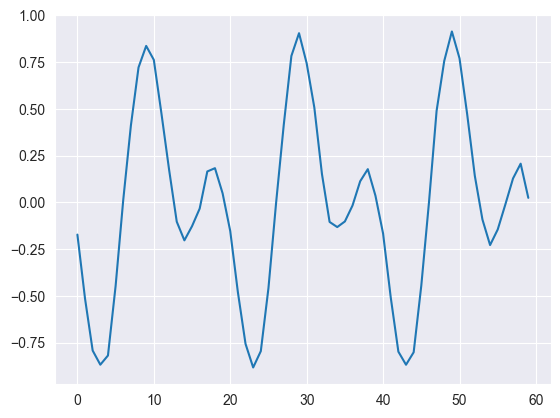

In [3]:
def sample_data(sample_size, signal_freq=60):
    import random
    def sine(X, signal_freq=60.):
        return (np.sin(2 * np.pi * (X) / signal_freq) + np.sin(4 * np.pi * (X) / signal_freq)) / 2.0

    def noisy(Y, noise_range=(-0.05, 0.05)):
        noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
        return Y + noise

    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    Y = noisy(sine(X + random_offset, signal_freq))
    return Y

data = sample_data(60, 20).reshape(-1, 1)
plt.plot(data)

In [4]:
hcnn = HCNN(data_dim=data.shape[1], hidden_dim=20, init_state_trainable=True)

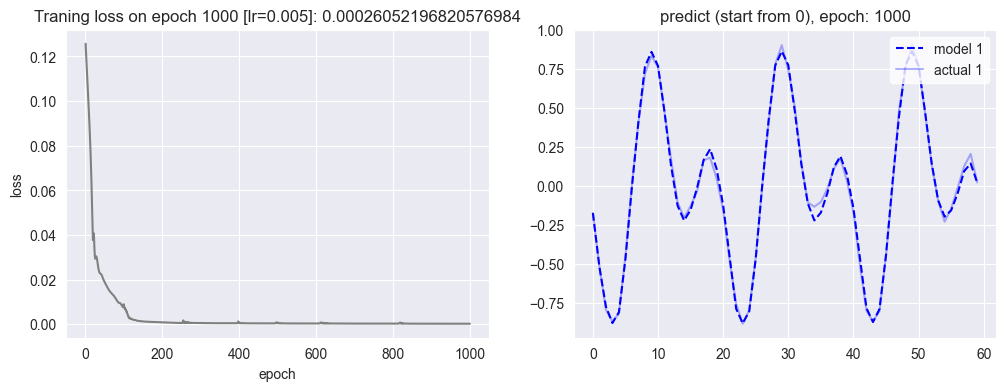

In [5]:
train_loss = hcnn.train(
    data, 
    lr=0.005, epochs=1000, 
    criterion=LogCosh.apply, # criterion=torch.nn.MSELoss() or criterion=LogCosh.apply
    plot_loss=False, plot_pred_train=True, verbose=False
)  

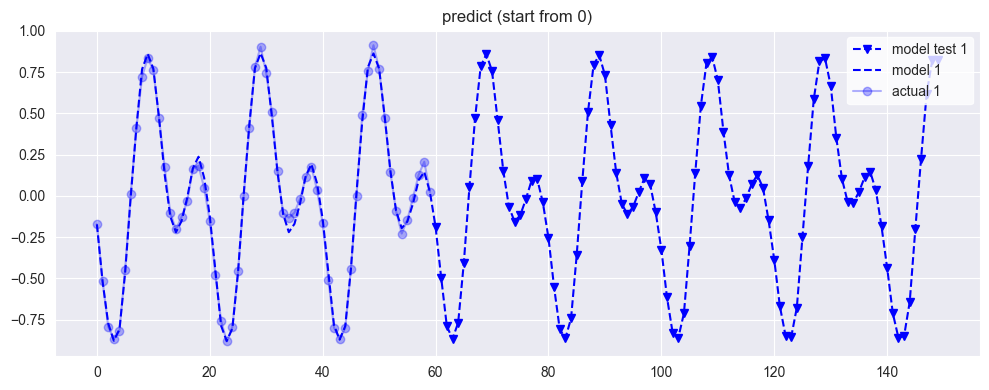

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))

pred = hcnn.sample(hcnn.hcnn.init_state, int(len(data))+1)
pred_test = hcnn.sample(hcnn.forward(hcnn.hcnn.init_state, len(data)), int(len(data)*1.5))
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
    ax.plot(np.arange(pred_test.shape[0]) + data.shape[0], pred_test[:, c], 'v--', label=f'model test {c+1}', color=colors[c], alpha=1)
    ax.plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
    ax.plot(data[:, c], 'o-', label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
legend_pred = ax.legend(frameon=True, loc='upper right')
legend_pred.get_frame().set_color('white')
plt.tight_layout()

# Airline passengers data

<Axes: >

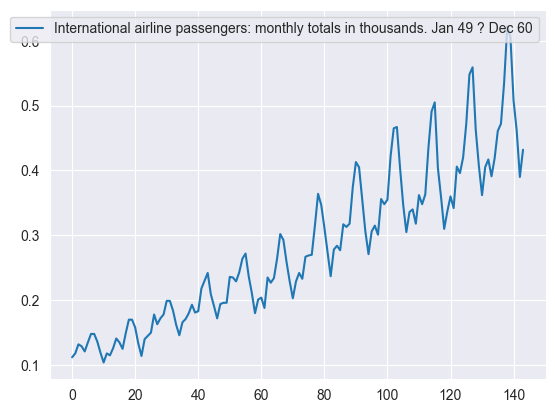

In [24]:
df = pd.read_csv(r"F:\hcnn\hcnn\examples\international-airline-passengers.csv", index_col=0)
df.index = range(0, len(df))
df /= 1000
df.plot()

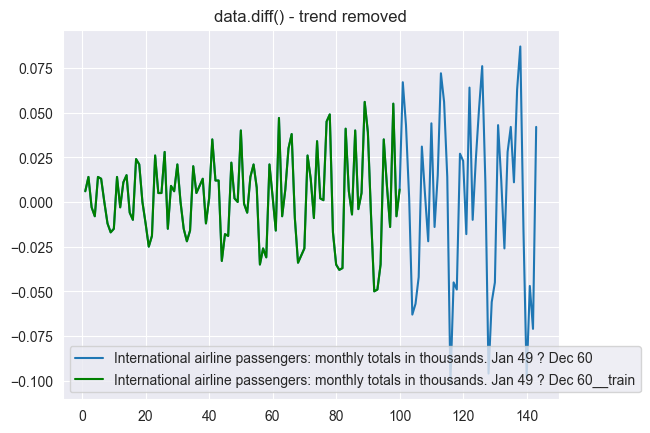

In [25]:
data = df.diff()  # remove trend
data = data.iloc[1:]
train_test_split_index = 100
data_train = data[:train_test_split_index]

fig, ax = plt.subplots()
data.plot(ax=ax, title='data.diff() - trend removed')
data_train.rename(columns={c:'{}__train'.format(c) for c in data_train.columns}).plot(ax=ax, color='g')
plt.show()

In [26]:
hcnn = HCNN(data_dim=data_train.shape[1], hidden_dim=100, sparsity=0.5, init_state_trainable=False)
init_state = hcnn.init_state()

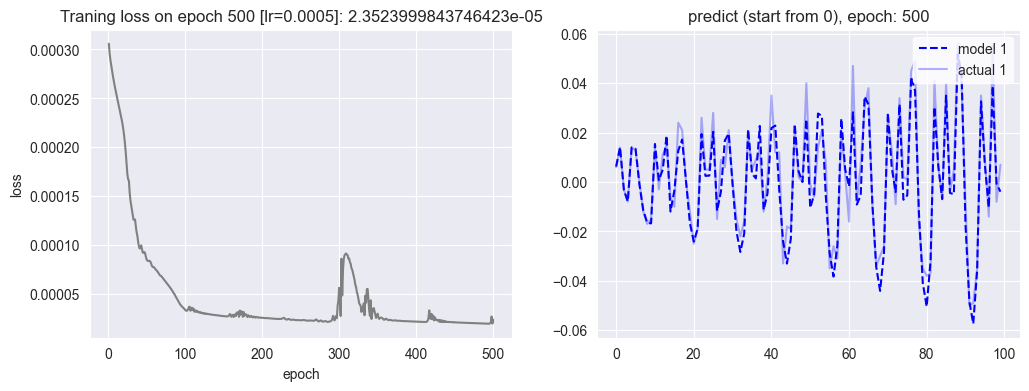

In [27]:
train_loss = hcnn.train(
    data_train.values, 
    init_state, 
    lr=0.0005, epochs=500, 
    criterion=LogCosh.apply, 
    plot_pred_train=True
)

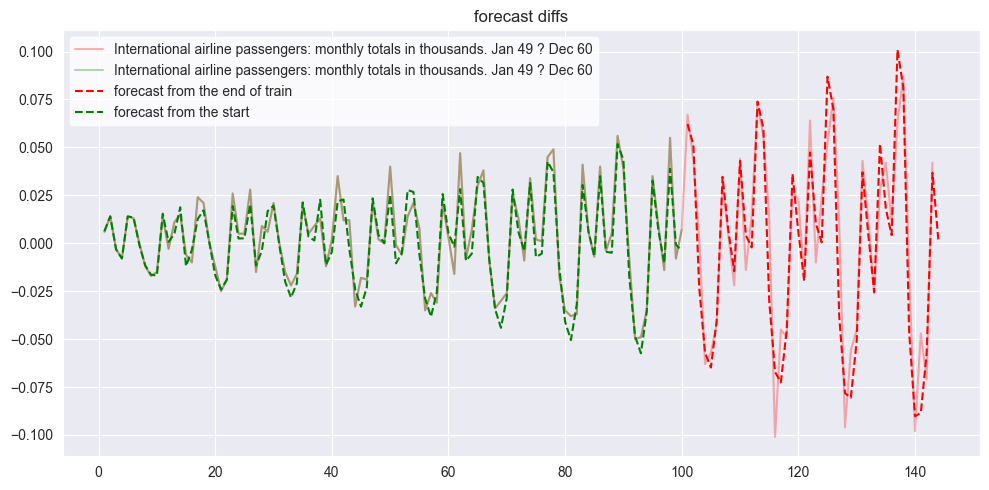

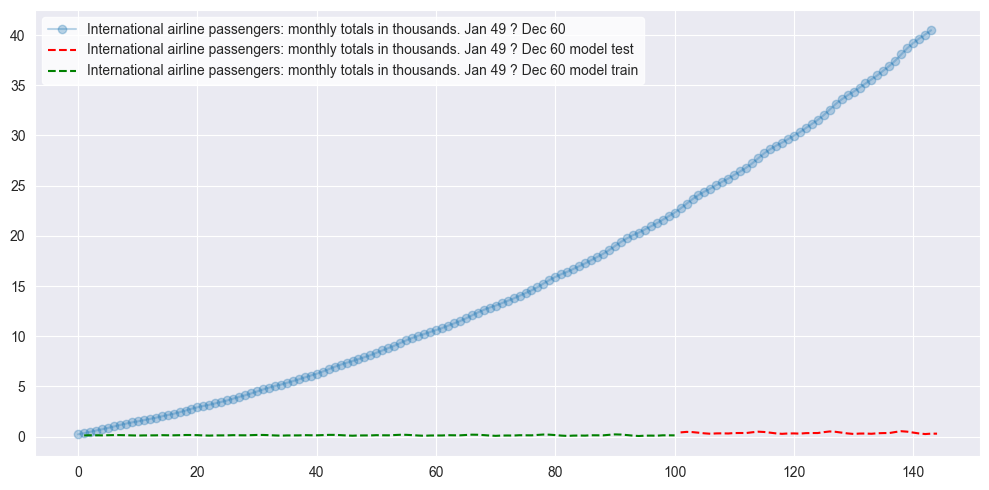

In [28]:
y_pred_test = hcnn.sample(hcnn.forward(init_state, len(data_train)), len(data)-len(data_train))
y_pred = hcnn.sample(init_state, len(data_train))

# PLOT forecast of diffs
fig, ax = plt.subplots(figsize=(10, 5))
data.rename(columns={'international_airline_passengers': 'data'}).plot(ax=ax, title='forecast diffs', color='r', alpha=0.3)
data_train.rename(columns={'international_airline_passengers': 'data train'}).plot(ax=ax, color='g', alpha=0.3)
ax.plot(np.arange(1, y_pred_test.shape[0]+1) + len(data_train), y_pred_test[:, 0], 'r--', label=f'forecast from the end of train')
ax.plot(data_train.index, y_pred[:, 0], 'g--', label=f'forecast from the start')
legend_pred = ax.legend(frameon=True, loc='upper left')
legend_pred.get_frame().set_color('white')
plt.tight_layout()
plt.show()

# PLOT FORECAST after diff inverse transform
def diff_inverse_transform(df, first_row):
    df_ = first_row
    for i in range(df.shape[0]):
        row = pd.DataFrame(data=df.iloc[[i]].values + df_.iloc[[i]].values, 
                           columns=df.columns, index=df.iloc[[i]].index)
        # Concatenate instead of appending
        df_ = pd.concat([df_, row])
    return df_.iloc[1:]

# def diff_inverse_transform(df, first_row, max = 73442.25, min =  41132.5):
#     df_ = first_row.copy()  # Copy to avoid modifying the original
#     for i in range(len(df)):
#         # Compute the row and ensure it's 2D
#         row_values = (max - min)*(df.iloc[[i]].values) + min  # Use last row of df_ for addition
#         row = pd.DataFrame(
#             data=row_values,  # Ensure data is 2D
#             columns=df.columns,
#             index=df.iloc[[i]].index,
#         )
#         # Concatenate instead of appending
#         df_ = pd.concat([df_, row])
#     return df_.iloc[1:]  # Drop the first row if it was only for initialization


y_pred_test = pd.DataFrame(data=y_pred_test, columns=df.columns)#.rename('forecast from the end of train'])
y_pred_test.index = data.loc[data_train.index[-1]+1:].index
df_forecast_test = diff_inverse_transform(y_pred_test, df.loc[[data_train.index[-1]]])
df_forecast_test.rename(columns={c: '{} model test'.format(c) for c in df_forecast_test.columns}, inplace=True)

y_pred = pd.DataFrame(data=y_pred, columns=df.columns, index=data_train.index) # columns=['forecast from the start']
df_forecast = diff_inverse_transform(y_pred, df.loc[[0]])
df_forecast.rename(columns={c: '{} model train'.format(c) for c in df_forecast.columns}, inplace=True)

df = diff_inverse_transform(df, df.loc[[0]])
    
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax, style='o-', alpha=0.3)
df_forecast_test.plot(ax=ax, style='r--')
df_forecast.plot(ax=ax, style='g--')
legend_pred = ax.legend(frameon=True, loc='upper left')
legend_pred.get_frame().set_color('white')
plt.tight_layout()